In [46]:
import os
import pandas as pd
import numpy as np
from pathlib import Path
from ast import literal_eval

In [28]:
PROJECT_ROOT = Path(os.getcwd()).parent
sec_filing_embedding_path = PROJECT_ROOT / "src" / "data" / "staged_chunks"/ "filings_staged.csv"
directives_embedding_path = PROJECT_ROOT / "src" / "data" / "staged_chunks"/ "regulations_staged.csv"
semantic_analysis_path = PROJECT_ROOT / "src" / "data" / "sematic_analysis"
sec_filing_embedding_path, directives_embedding_path

(WindowsPath('D:/Hackathons/Datathon/src/data/staged_chunks/filings_staged.csv'),
 WindowsPath('D:/Hackathons/Datathon/src/data/staged_chunks/regulations_staged.csv'))

In [50]:
def aggregate_embeddings(input_csv, output_csv):
    """
    Memory-efficient aggregation of embeddings by file_name.
    Supports multilingual text and safely handles empty embeddings.
    """
    output_path = Path(output_csv)
    output_path.parent.mkdir(parents=True, exist_ok=True)

    # Initialize output CSV
    pd.DataFrame(columns=['file_name', 'embedding', 'total_chunks']).to_csv(output_path, index=False, encoding='utf-8')

    file_embeddings = {}

    print(f"Reading {input_csv} in chunks...")

    for chunk in pd.read_csv(input_csv, chunksize=10000, usecols=['file_name', 'chunk_index', 'embedding'], encoding='utf-8'):
        for _, row in chunk.iterrows():
            fname = row['file_name']
            try:
                emb = np.array(literal_eval(row['embedding']))
                if emb.size == 0:
                    continue  # skip empty embeddings
            except Exception as e:
                print(f"Skipping {fname}: failed to parse embedding ({e})")
                continue

            if fname not in file_embeddings:
                file_embeddings[fname] = []
            file_embeddings[fname].append(emb)

    print(f"Aggregating embeddings for {len(file_embeddings)} files...")

    for i, (fname, embeddings) in enumerate(file_embeddings.items(), start=1):
        if len(embeddings) == 0:
            print(f"Skipping {fname}: no valid embeddings")
            continue

        avg_emb = np.mean(np.vstack(embeddings), axis=0)
        pd.DataFrame([{
            'file_name': fname,
            'embedding': avg_emb.tolist(),
            'total_chunks': len(embeddings)
        }]).to_csv(output_path, mode='a', header=False, index=False, encoding='utf-8')

        if i % 50 == 0 or i == len(file_embeddings):
            print(f"Aggregated {i}/{len(file_embeddings)} files")

    print(f"Done! Results saved to {output_path}")
    return pd.read_csv(output_path, encoding='utf-8')

In [52]:
# Load and aggregate embeddings
company_embeddings = aggregate_embeddings(sec_filing_embedding_path, semantic_analysis_path/"final_filing_embedding.csv")
company_embeddings

Reading D:\Hackathons\Datathon\src\data\staged_chunks\filings_staged.csv in chunks...
Aggregating embeddings for 500 files...
Aggregated 50/500 files
Aggregated 100/500 files
Aggregated 150/500 files
Aggregated 200/500 files
Aggregated 250/500 files
Aggregated 300/500 files
Aggregated 350/500 files
Aggregated 400/500 files
Aggregated 450/500 files
Aggregated 500/500 files
Done! Results saved to D:\Hackathons\Datathon\src\data\sematic_analysis\final_filing_embedding.csv


,file_name,embedding,total_chunks
0,2024-12-20-10k-A.html,"[-0.03295121659175493, 0.046345890552038325, 0...",140
1,2024-11-01-10k-AAPL.html,"[-0.043687890799316974, 0.026154279139258767, ...",56
2,2025-02-14-10k-ABBV.html,"[-0.04420676961490244, 0.02193104189746009, 0....",128
3,2025-02-13-10k-ABNB.html,"[-0.04581543982655195, 0.04105091252733536, 0....",116
4,2025-02-21-10k-ABT.html,"[-0.030612685684380785, 0.02766931059827306, -...",98
...,...,...,...
495,2025-02-24-10k-XYZ.html,"[-0.029009922243033847, 0.03522906764410436, 0...",75
496,2025-02-19-10k-YUM.html,"[-0.020204203639384674, 0.03820105690224949, 0...",59
497,2025-02-25-10k-ZBH.html,"[-0.040830594291698864, 0.03061359733216126, 0...",55
498,2025-02-13-10k-ZBRA.html,"[-0.033071460329931766, 0.018501580647397334, ...",41


In [51]:
directive_embeddings = aggregate_embeddings(directives_embedding_path, semantic_analysis_path /"final_directive_embedding.csv")
directive_embeddings

Reading D:\Hackathons\Datathon\src\data\staged_chunks\regulations_staged.csv in chunks...
Aggregating embeddings for 6 files...
Aggregated 6/6 files
Done! Results saved to D:\Hackathons\Datathon\src\data\sematic_analysis\final_directive_embedding.csv


,file_name,embedding,total_chunks
0,1.DIRECTIVE (UE) 20192161 DU PARLEMENT EUROPÉE...,"[0.002921653096564114, 0.01209549106387121, 0....",31
1,2.H.R.1 - One Big Beautiful Bill Act.xml,"[0.0022854857152052564, 0.026692700408314105, ...",252
2,3.H.R.5376 - Inflation Reduction Act of 2022.xml,"[0.013346302206560341, 0.031750971140599875, 0...",215
3,4.REGULATION (EU) 20241689 OF THE EUROPEAN PAR...,"[0.014366325256836803, 0.051186291601683136, 0...",171
4,5.中华人民共和国能源法__中国政府网.html,"[0.03905266656407288, 0.008568796628553952, 0....",14
5,6.人工知能関連技術の研究開発及び活用の推進に関する法律.html,"[0.012351224198937416, 0.026664201428906784, 0...",9


## Computing semantic similarity

In [58]:
from numpy.linalg import norm

In [59]:
# normalize embeddings for better cosine similarity
def normalize_embeddings(df):
    df['embedding'] = df['embedding'].apply(lambda x: np.array(literal_eval(x)) if isinstance(x, str) else np.array(x))
    df['embedding'] = df['embedding'].apply(lambda x: x / norm(x) if norm(x) != 0 else x)
    return df

In [61]:
company_embeddings = normalize_embeddings(company_embeddings)
company_embeddings

,file_name,embedding,total_chunks
0,2024-12-20-10k-A.html,"[-0.05359048657758883, 0.07537502655294626, 0....",140
1,2024-11-01-10k-AAPL.html,"[-0.06065360765598607, 0.03631100875811894, 0....",56
2,2025-02-14-10k-ABBV.html,"[-0.06707622819291974, 0.033276613144033344, 0...",128
3,2025-02-13-10k-ABNB.html,"[-0.07620179013398247, 0.0682772670754453, 0.0...",116
4,2025-02-21-10k-ABT.html,"[-0.04222574094832188, 0.03816578374034836, -0...",98
...,...,...,...
495,2025-02-24-10k-XYZ.html,"[-0.051954759797065965, 0.06309281810514142, 0...",75
496,2025-02-19-10k-YUM.html,"[-0.03332913375719067, 0.06301699180457779, 0....",59
497,2025-02-25-10k-ZBH.html,"[-0.07058811296724876, 0.05292492319309203, 0....",55
498,2025-02-13-10k-ZBRA.html,"[-0.056222254297583055, 0.031453118842888435, ...",41


In [62]:
directive_embeddings = normalize_embeddings(directive_embeddings)
directive_embeddings

,file_name,embedding,total_chunks
0,1.DIRECTIVE (UE) 20192161 DU PARLEMENT EUROPÉE...,"[0.003978565416482589, 0.016471052808659882, 0...",31
1,2.H.R.1 - One Big Beautiful Bill Act.xml,"[0.004576830249284518, 0.05345382727666248, 0....",252
2,3.H.R.5376 - Inflation Reduction Act of 2022.xml,"[0.024638276476379575, 0.05861467792712774, 0....",215
3,4.REGULATION (EU) 20241689 OF THE EUROPEAN PAR...,"[0.01925650477824619, 0.06860968627585842, 0.0...",171
4,5.中华人民共和国能源法__中国政府网.html,"[0.051117921391352385, 0.011216111754065698, 0...",14
5,6.人工知能関連技術の研究開発及び活用の推進に関する法律.html,"[0.016213553684133176, 0.03500231672171521, 0....",9


In [63]:
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm

In [64]:
def compute_company_regulation_similarity(companies, directives, top_k=5):
    relations = []
    company_embs = np.vstack(companies['embedding'])
    directive_embs = np.vstack(directives['embedding'])

    sim_matrix = cosine_similarity(company_embs, directive_embs)

    for i, company in enumerate(tqdm(companies['file_name'], desc="Mapping relationships")):
        top_indices = np.argsort(sim_matrix[i])[::-1][:top_k]
        for j in top_indices:
            relations.append({
                'company_file': company,
                'directive_file': directives.iloc[j]['file_name'],
                'similarity': sim_matrix[i, j]
            })
    return pd.DataFrame(relations)

In [65]:
company_directive_links = compute_company_regulation_similarity(company_embeddings, directive_embeddings, top_k=5)
company_directive_links

Mapping relationships: 100%|██████████| 500/500 [00:00<00:00, 8333.80it/s]


,company_file,directive_file,similarity
0,2024-12-20-10k-A.html,2.H.R.1 - One Big Beautiful Bill Act.xml,0.357613
1,2024-12-20-10k-A.html,3.H.R.5376 - Inflation Reduction Act of 2022.xml,0.337516
2,2024-12-20-10k-A.html,4.REGULATION (EU) 20241689 OF THE EUROPEAN PAR...,0.272558
3,2024-12-20-10k-A.html,6.人工知能関連技術の研究開発及び活用の推進に関する法律.html,0.222924
4,2024-12-20-10k-A.html,1.DIRECTIVE (UE) 20192161 DU PARLEMENT EUROPÉE...,0.209902
...,...,...,...
2495,2025-02-13-10k-ZTS.html,2.H.R.1 - One Big Beautiful Bill Act.xml,0.439151
2496,2025-02-13-10k-ZTS.html,3.H.R.5376 - Inflation Reduction Act of 2022.xml,0.406131
2497,2025-02-13-10k-ZTS.html,4.REGULATION (EU) 20241689 OF THE EUROPEAN PAR...,0.276412
2498,2025-02-13-10k-ZTS.html,6.人工知能関連技術の研究開発及び活用の推進に関する法律.html,0.250274


In [66]:
# Building semantic graph
import networkx as nx

In [196]:
G = nx.Graph()

# Add nodes for companies
for _, row in company_embeddings.iterrows():
    G.add_node(row['file_name'], type='company')

# Add nodes for directives
for _, row in directive_embeddings.iterrows():
    G.add_node(row['file_name'], type='directive')

# Add edges for strong similarity links
for _, row in company_directive_links.iterrows():
    if row['similarity'] > 0.3:  # threshold, can be tuned
        G.add_edge(row['company_file'], row['directive_file'], weight=row['similarity'])

In [197]:
import matplotlib.pyplot as plt

Top connected (most affected) companies: [('2.H.R.1 - One Big Beautiful Bill Act.xml', 475), ('3.H.R.5376 - Inflation Reduction Act of 2022.xml', 453), ('4.REGULATION (EU) 20241689 OF THE EUROPEAN PARLIAMENT AND OF THE COUNCIL.html', 47), ('5.中华人民共和国能源法__中国政府网.html', 24), ('6.人工知能関連技術の研究開発及び活用の推進に関する法律.html', 11), ('2025-02-20-10k-GDDY.html', 5), ('2025-01-31-10k-ISRG.html', 5), ('2025-01-30-10k-META.html', 5), ('2025-02-18-10k-PLTR.html', 5), ('1.DIRECTIVE (UE) 20192161 DU PARLEMENT EUROPÉEN ET DU CONSEIL.html', 5)]


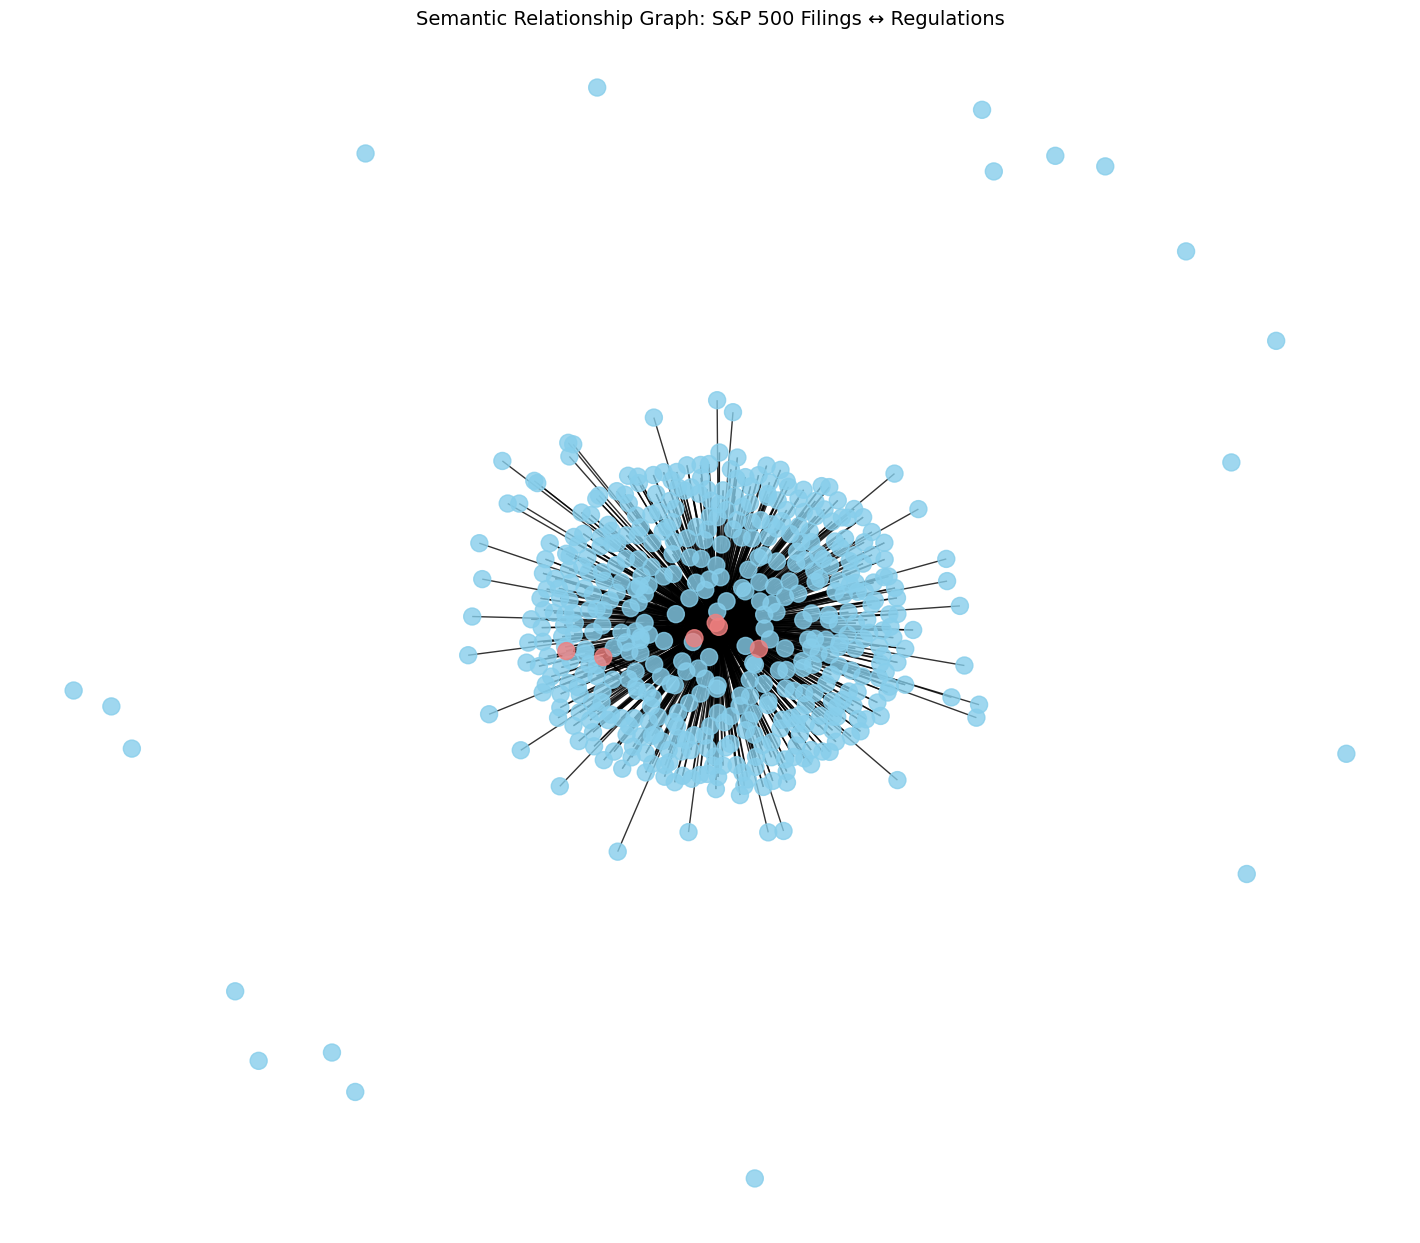

In [198]:
plt.figure(figsize=(14, 12))
pos = nx.spring_layout(G, k=0.7, seed=42)
node_colors = ['skyblue' if G.nodes[n]['type']=='company' else 'lightcoral' for n in G.nodes]

nx.draw(G, pos, with_labels=False, node_size=150, node_color=node_colors, alpha=0.8)
plt.title("Semantic Relationship Graph: S&P 500 Filings ↔ Regulations", fontsize=14)
deg = dict(G.degree())
top_nodes = sorted(deg.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top connected (most affected) companies:", top_nodes)
plt.show()

In [163]:
from sklearn.decomposition import PCA
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.cm as cm

In [199]:
import numpy as np
import networkx as nx
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import plotly.graph_objects as go
import plotly.express as px

def visualize_semantic_network_embeddings(G, n_clusters=6, output_html="semantic_network.html"):
    """
    3D semantic network visualization:
    - Company nodes colored by embedding clusters
    - Directive nodes always labeled
    - Edge colors represent similarity
    - Node sizes represent average similarity of connected edges
    """
    # 1️⃣ Extract company embeddings
    company_nodes = [n for n, d in G.nodes(data=True) if d['type'] == 'company']
    company_embeddings = np.vstack([G.nodes[n]['embedding'] for n in company_nodes])

    # 2️⃣ Cluster companies for color
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(company_embeddings)
    company_labels = kmeans.labels_
    cluster_colors = px.colors.qualitative.Plotly
    if len(cluster_colors) < n_clusters:
        cluster_colors = cluster_colors * ((n_clusters // len(cluster_colors)) + 1)
    node_colors = {node: cluster_colors[label] for node, label in zip(company_nodes, company_labels)}

    # 3️⃣ Directive nodes color
    directive_nodes = [n for n, d in G.nodes(data=True) if d['type'] == 'directive']
    for node in directive_nodes:
        node_colors[node] = 'darkorange'

    # 4️⃣ Node sizes: based on average edge similarity
    node_sizes = []
    for node in G.nodes():
        edges = G.edges(node, data=True)
        if len(edges) == 0:
            avg_sim = 0.1
        else:
            avg_sim = np.mean([d['weight'] for _, _, d in edges])
        node_sizes.append(5 + 20 * avg_sim)  # scale for visibility

    # 5️⃣ Node coordinates
    pos = nx.spring_layout(G, dim=3, seed=42)
    Xn = [pos[n][0] for n in G.nodes()]
    Yn = [pos[n][1] for n in G.nodes()]
    Zn = [pos[n][2] for n in G.nodes()]

    # 6️⃣ Edge traces
    edge_x, edge_y, edge_z, edge_color = [], [], [], []
    weights = [d['weight'] for _, _, d in G.edges(data=True)]
    norm_weights = MinMaxScaler((0,1)).fit_transform(np.array(weights).reshape(-1,1)).flatten() if weights else []

    for i, (u, v, d) in enumerate(G.edges(data=True)):
        edge_x += [pos[u][0], pos[v][0], None]
        edge_y += [pos[u][1], pos[v][1], None]
        edge_z += [pos[u][2], pos[v][2], None]
        edge_color.append(norm_weights[i] if len(norm_weights) > 0 else 0.5)

    edge_trace = go.Scatter3d(
        x=edge_x, y=edge_y, z=edge_z,
        line=dict(width=2, color=edge_color, colorscale='Viridis'),
        hoverinfo='none', mode='lines', showlegend=False
    )

    # 7️⃣ Node trace
    node_texts = []
    for n in G.nodes():
        if G.nodes[n]['type'] == 'directive':
            node_texts.append(n)  # always show directives
        else:
            node_texts.append('')  # company names only on hover

    node_trace = go.Scatter3d(
        x=Xn, y=Yn, z=Zn,
        mode='markers+text',
        text=node_texts,
        hovertext=[n for n in G.nodes()],
        hoverinfo='text',
        textposition='top center',
        marker=dict(
            size=node_sizes,
            color=[node_colors[n] for n in G.nodes()],
            line=dict(width=0.5, color='black')
        ),
        showlegend=False
    )

    # 8️⃣ Create figure
    fig = go.Figure(data=[edge_trace, node_trace])
    fig.update_layout(
        title='Semantic Network: Companies vs Directives',
        width=1200, height=900,
        scene=dict(
            xaxis=dict(showbackground=False),
            yaxis=dict(showbackground=False),
            zaxis=dict(showbackground=False)
        ),
        margin=dict(l=0, r=0, b=0, t=50),
        hovermode='closest'
    )

    fig.write_html(output_html)
    fig.show()
    print(f"Visualization saved to {output_html}")


In [200]:
# Attach embeddings to nodes first
for _, row in company_embeddings.iterrows():
    G.nodes[row['file_name']]['embedding'] = np.array(row['embedding'])

for _, row in directive_embeddings.iterrows():
    G.nodes[row['file_name']]['embedding'] = np.array(row['embedding'])

# Visualize
visualize_semantic_network_embeddings(G, n_clusters=10)


Visualization saved to semantic_network.html


In [201]:
import networkx as nx
import plotly.graph_objects as go
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from difflib import get_close_matches
# only for directives
def visualize_directive_focus(G, directive_name, top_k=5, output_html="directive_focus.html"):
    """
    Visualize a directive and its closest related companies in 3D.
    Node sizes scale with number of connections (log/normalized).
    Edge colors reflect similarity.
    """
    # --- 0️⃣ Check directive existence ---
    if directive_name not in G.nodes or G.nodes[directive_name]['type'] != 'directive':
        # Suggest close matches
        directives = [n for n, d in G.nodes(data=True) if d['type']=='directive']
        closest = get_close_matches(directive_name, directives, n=3)
        raise ValueError(
            f"'{directive_name}' not found or not a directive node.\n"
            f"Closest matches: {closest}"
        )

    # --- 1️⃣ Find top related companies ---
    edges = [(u, v, d['weight']) for u, v, d in G.edges(data=True)]

    # Filter edges connected to directive
    directive_edges = [(u, v, w) for u, v, w in edges if directive_name in [u, v]]
    if len(directive_edges) == 0:
        print("No connected companies found for this directive.")
        return

    # Sort by weight (similarity)
    directive_edges.sort(key=lambda x: x[2], reverse=True)
    top_edges = directive_edges[:top_k]

    # Collect nodes to show
    nodes_to_show = set([directive_name])
    for u, v, w in top_edges:
        nodes_to_show.add(u)
        nodes_to_show.add(v)

    # Include other directives connected to these companies
    for node in list(nodes_to_show):
        if G.nodes[node]['type']=='company':
            connected_directives = [n for n in G.neighbors(node) if G.nodes[n]['type']=='directive']
            nodes_to_show.update(connected_directives)

    # --- 2️⃣ Build positions (spring layout 3D) ---
    subG = G.subgraph(nodes_to_show)
    pos = nx.spring_layout(subG, dim=3, seed=42)

    # --- 3️⃣ Build node traces ---
    node_x, node_y, node_z = [], [], []
    node_size, node_color, node_text = [], [], []

    for n in subG.nodes:
        x, y, z = pos[n]
        node_x.append(x)
        node_y.append(y)
        node_z.append(z)

        # Node size based on degree (number of connections)
        size = np.log1p(subG.degree[n]) * 5 + 5
        node_size.append(size)

        # Color: directive vs company
        color = "darkorange" if subG.nodes[n]['type']=='directive' else "steelblue"
        node_color.append(color)

        # Only show name on hover
        node_text.append(n)

    node_trace = go.Scatter3d(
        x=node_x, y=node_y, z=node_z,
        mode='markers',
        marker=dict(size=node_size, color=node_color),
        text=node_text,
        hoverinfo='text'
    )

    # --- 4️⃣ Build edge traces ---
    edge_x, edge_y, edge_z, edge_color = [], [], [], []

    for u, v, w in subG.edges(data=True):
        x0, y0, z0 = pos[u]
        x1, y1, z1 = pos[v]
        edge_x += [x0, x1, None]
        edge_y += [y0, y1, None]
        edge_z += [z0, z1, None]
        # Normalize similarity for color
        norm_w = (w['weight'] - 0) / (1 - 0)  # assuming weights [0,1]
        edge_color.append(norm_w)

    # Use colorscale for edges
    edge_trace = go.Scatter3d(
        x=edge_x, y=edge_y, z=edge_z,
        line=dict(width=2, color='lightgray'),
        hoverinfo='none',
        mode='lines'
    )

    # --- 5️⃣ Plot figure ---
    fig = go.Figure(data=[edge_trace, node_trace])
    fig.update_layout(
        showlegend=False,
        scene=dict(
            xaxis=dict(showbackground=False),
            yaxis=dict(showbackground=False),
            zaxis=dict(showbackground=False),
            bgcolor='white'
        ),
        margin=dict(l=0, r=0, b=0, t=0)
    )

    fig.write_html(output_html)
    print(f"Directive focus visualization saved to {output_html}")
    fig.show()


In [202]:
visualize_directive_focus(G, "6.人工知能関連技術の研究開発及び活用の推進に関する法律.html", top_k=10)

Directive focus visualization saved to directive_focus.html


In [203]:
import networkx as nx
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import plotly.graph_objects as go
from difflib import get_close_matches

def visualize_company_focus(G, company_name, top_k=5, output_html="focus_company.html"):
    """
    Visualize a single company's closest relationships in 3D.
    Shows the selected company, top-k closest companies, and connected directives.
    Node sizes scale with number of connections.
    Edge colors reflect similarity.
    Only relevant edges are shown.
    """
    if company_name not in G.nodes or G.nodes[company_name]['type'] != 'company':
        companies = [n for n, d in G.nodes(data=True) if d['type']=='company']
        closest = get_close_matches(company_name, companies, n=3)
        raise ValueError(
            f"'{company_name}' not found or not a company node.\n"
            f"Closest matches: {closest}"
        )

    # --- 1️⃣ Compute positions ---
    pos = nx.spring_layout(G, dim=3, seed=42)

    # --- 2️⃣ Find top related companies ---
    company_edges = [(u, v, d['weight']) for u, v, d in G.edges(data=True)
                     if u == company_name or v == company_name]

    # pick top_k by weight
    top_edges = sorted(company_edges, key=lambda x: x[2], reverse=True)[:top_k]

    # nodes to show
    company_nodes = set([company_name])
    directive_nodes = set()

    for u, v, w in top_edges:
        if G.nodes[u]['type'] == 'company':
            company_nodes.add(u)
        if G.nodes[v]['type'] == 'company':
            company_nodes.add(v)
        if G.nodes[u]['type'] == 'directive':
            directive_nodes.add(u)
        if G.nodes[v]['type'] == 'directive':
            directive_nodes.add(v)

    # --- 3️⃣ Only show edges between these nodes ---
    edges_to_show = [(u, v, d['weight']) for u, v, d in G.edges(data=True)
                     if (u in company_nodes or v in company_nodes) and
                        (u in directive_nodes or v in directive_nodes or u in company_nodes or v in company_nodes)]

    # --- 4️⃣ Edge trace ---
    weights = [w for _, _, w in edges_to_show]
    if len(weights) == 0:
        weights = [0.1]
    scaler = MinMaxScaler()
    scaled_weights = scaler.fit_transform(np.array(weights).reshape(-1, 1)).flatten()

    edge_trace_x, edge_trace_y, edge_trace_z, edge_trace_color = [], [], [], []
    for (u, v, w), w_scaled in zip(edges_to_show, scaled_weights):
        x0, y0, z0 = list(pos[u])
        x1, y1, z1 = list(pos[v])
        edge_trace_x += [x0, x1, None]
        edge_trace_y += [y0, y1, None]
        edge_trace_z += [z0, z1, None]
        edge_trace_color += [f'rgba({int(255*(1-w_scaled))},0,{int(255*w_scaled)},0.7)']*3

    edge_trace = go.Scatter3d(
        x=edge_trace_x, y=edge_trace_y, z=edge_trace_z,
        mode='lines',
        line=dict(width=2, color=edge_trace_color),
        hoverinfo='none'
    )

    # --- 5️⃣ Node trace ---
    node_size_map = {}
    for n in company_nodes | directive_nodes:
        connections = len([nbr for nbr in G.neighbors(n) if nbr in company_nodes or nbr in directive_nodes])
        node_size_map[n] = 10 + 20 * np.log1p(connections)

    # Cluster companies for color
    company_embs = np.array([G.nodes[n]['embedding'] for n in company_nodes])
    if len(company_nodes) > 1 and len(company_embs) >= 2:
        n_clusters = min(5, len(company_nodes))
        kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(company_embs)
        colors = kmeans.labels_
        company_color_map = {n: colors[i] for i, n in enumerate(company_nodes)}
    else:
        company_color_map = {n: 0 for n in company_nodes}

    # Company nodes
    node_trace = go.Scatter3d(
        x=[], y=[], z=[],
        mode='markers+text',
        marker=dict(
            size=[],
            color=[],
            colorscale='Viridis',
            showscale=True,
            colorbar=dict(title="Company Cluster")
        ),
        text=[],
        hoverinfo='text'
    )
    for n in company_nodes:
        x, y, z = pos[n]
        node_trace['x'] += (x,)
        node_trace['y'] += (y,)
        node_trace['z'] += (z,)
        node_trace['marker']['size'] += (node_size_map[n],)
        node_trace['marker']['color'] += (company_color_map[n],)
        node_trace['text'] += (n,)

    # Directive nodes
    directive_trace = go.Scatter3d(
        x=[], y=[], z=[],
        mode='markers+text',
        marker=dict(size=[], color='darkorange'),
        text=[],
        hoverinfo='text'
    )
    for n in directive_nodes:
        x, y, z = pos[n]
        directive_trace['x'] += (x,)
        directive_trace['y'] += (y,)
        directive_trace['z'] += (z,)
        directive_trace['marker']['size'] += (15,)
        directive_trace['text'] += (n,)

    # --- 6️⃣ Build figure ---
    fig = go.Figure(data=[edge_trace, node_trace, directive_trace])
    fig.update_layout(
        scene=dict(
            xaxis=dict(showbackground=False),
            yaxis=dict(showbackground=False),
            zaxis=dict(showbackground=False)
        ),
        margin=dict(l=0, r=0, b=0, t=0),
        showlegend=False
    )

    fig.write_html(output_html)
    fig.show()
    print(f"Visualization saved to {output_html}")


In [204]:
# Visualize top 5 closest relations for a single company
visualize_company_focus(
    G,
    "2025-02-19-10k-PFG.html",
    top_k=5,
    output_html="focus_company.html"
)


Visualization saved to focus_company.html
